Automated Plant Leaf Disease Detection

Neural Network to analyze images of a plant leaf to identify various common diseases. It is indented to be used in the **Agricultural Sector** to result in early detection of diseases.

In [3]:
# Import Libraries
import numpy as np
import matplotlib.pyplot as plt
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torch.utils.data.sampler import SubsetRandomSampler
import torchvision.transforms as transforms
import os
import shutil
import pandas as pd

In [4]:
# INITIALIZE GLOBAL VARIABLES FOR THE PROJECT 
IMAGE_RESOLUTION = (244, 244)
TOTAL_PIXELS = 256 * 256 * 3
PRIMARY_DATASET_PATH = "Dataset"
TRAIN_DATASET_PATH = "Train_Folder"
VAL_DATASET_PATH = "Val_Folder"
TEST_DATASET_PATH = "Test_Folder"
RESNET_FEAUTURES_BASE_PATH =  "Resnet_Features"
TRAIN_VAL_TEST_SPLIT = (0.7,0.15,0.15)
MAX_IMAGES_PER_CLASS = 1000
PRACTICE_PRIMARY_DATASET_PATH = "TestDataset"
NEW_DATASET_PATH = "New_Dataset"
DEMO_DATASET_PATH = "Demo_Dataset"


# Data Cleaning

## Merge multiple datasets into a Central Dataset Folder

In [10]:
def changeImgDirectory(old_directory, new_directory):
    if not os.path.exists(new_directory):
        os.mkdir( new_directory )

    for sub_direcotry in os.listdir(old_directory):
        shutil.move( old_directory + "\\" + sub_direcotry, new_directory )

    print( f"Copied Directory {old_directory} to {new_directory}" )

def unsqueezeImgDirectory(path, directory):
    for sub_directory in os.listdir(path + "\\" + directory):
        new_sub_directory = sub_directory.title()
        new_sub_directory = sub_directory.replace( " ", "" )
        new_sub_directory = directory + "_" + new_sub_directory

        new_directory = path + "\\" + new_sub_directory
        shutil.move(path + "\\" + directory + "\\" + sub_directory, new_directory)
        os.rmdir(path + "\\" + directory)
    print( f"Unsqueezed Directory {directory}" )

def createDirectoryFromCSV(path, directory, path_to_csv):
    data = pd.read_excel(path_to_csv)

    category_to_label = {}
    for index in range(len(data)):
        entry = data.iloc[index]

        img_name = entry.iloc[0]
        category = entry.iloc[1]

        old_img_path = path + "\\" + directory + "\\" + img_name
        
        if category not in category_to_label:
            label = category.replace("_", " ")
            label = label.title()
            label = label.replace(" ", "")
            
            category_to_label[category] = label
            new_img_path = path + "\\" + label

            os.mkdir(new_img_path)
        
        new_img_path = path + "\\" + category_to_label[category] + "\\" + img_name

        shutil.move( old_img_path, new_img_path )
    print( "Images segmented into directories" )

def modifyImageName(dataset_path):
    for label in os.listdir(dataset_path):
        label_path = dataset_path + "\\" + label
        count = 1
        for img_name in os.listdir(label_path):
            img_path = label_path + "\\" + img_name
            new_img_path = label_path + "\\" + f"{label}_{count}.jpg"
            count += 1
            os.rename( img_path, new_img_path )
    print("Images are renamed to the readable names")
    


In [9]:
os.mkdir(r"Dataset")
changeImgDirectory(r"Citrus Plant Dataset\Leaves", r"Dataset\Citrus")
changeImgDirectory(r"Coffee Plant Dataset\Photos", r"Dataset\Coffee")
changeImgDirectory(r"Pear Dataset\Leaves", r"Dataset\Pear")
changeImgDirectory(r"plantvillage dataset\color", r"Dataset")

Copied Directory Citrus Plant Dataset\Leaves to Dataset\Citrus
Copied Directory Coffee Plant Dataset\Photos to Dataset\Coffee
Copied Directory Pear Dataset\Leaves to Dataset\Pear
Copied Directory plantvillage dataset\color to Dataset


In [ ]:
unsqueezeImgDirectory(r"Dataset", r"Citrus")
unsqueezeImgDirectory(r"Dataset", r"Pear")

Unsqueezed Directory Citrus
Unsqueezed Directory Pear


In [ ]:
PATH = r"Dataset"
directory = r"Coffee"
path_to_csv = r"Coffee Plant Dataset\Annotations\RoCoLE-classes.xlsx"
createDirectoryFromCSV(PATH, directory, path_to_csv)

Images segmented into directories


In [ ]:
PATH = r"Dataset"
modifyImageName(PATH)

Images are renamed to the readable names


In [11]:
# Function to Create the csv file
def generateCSV(dataset_path):

    d = {'Image_Path': [], 'Label': [], 'Plant': [], 'Disease': [] }
    data = pd.DataFrame(data=d)

    for label in os.listdir(dataset_path):
        label_path = dataset_path + "\\" + label
        for img_name in os.listdir(label_path):
            img_path = label_path + "\\" + img_name
            data = data.append( {'Image_Path': img_path, 'Label': label, 'Plant': "", 'Disease': "" }, ignore_index = True )            
        print( f"Label {label} is added to the CSV " )
    
    dataset_csv_path = 'test_dataset_csv.csv'
    data.to_csv(dataset_csv_path, index=False)
    print( f"CSV file is generated and stored at {dataset_csv_path}" )

    return dataset_csv_path


In [83]:
dataset_path = r"Dataset"
dataset_csv_path = generateCSV(dataset_path)

Label Apple_AppleScab is added to the CSV 
Label Apple_BlackRot is added to the CSV 
Label Apple_CedarAppleRust is added to the CSV 
Label Apple_Healthy is added to the CSV 
Label Blueberry_Healthy is added to the CSV 
Label Cherry_Healthy is added to the CSV 
Label Cherry_PowderyMildew is added to the CSV 
Label Citrus_BlackSpot is added to the CSV 
Label Citrus_Canker is added to the CSV 
Label Citrus_Greening is added to the CSV 
Label Citrus_Healthy is added to the CSV 
Label Citrus_Melanose is added to the CSV 
Label Coffee_Healthy is added to the CSV 
Label Coffee_RedSpiderMite is added to the CSV 
Label Coffee_RustLevel1 is added to the CSV 
Label Coffee_RustLevel2 is added to the CSV 
Label Coffee_RustLevel3 is added to the CSV 
Label Coffee_RustLevel4 is added to the CSV 
Label Corn_CercosporaLeafSpot is added to the CSV 
Label Corn_CommonRust is added to the CSV 
Label Corn_Healthy is added to the CSV 
Label Corn_NorthernLeafBlight is added to the CSV 
Label Grape_BlackRot is

## Image Proccessing: Resize and Augmentation

In [6]:
from PIL import Image, ImageEnhance
import random

def augmentation(img):
  if img is None:
    return None

  a = random.randint(1, 4)
  if a == 1:
    transform = transforms.Compose([transforms.GaussianBlur(kernel_size=21)])
    img = transform(img)
  elif a == 2:
    transform = transforms.Compose([transforms.RandomHorizontalFlip(p=0.5)])
    img = transform(img)
  elif a == 3:
    img2 = ImageEnhance.Brightness(img)
    img = img2.enhance(1.5)
  else:
    img2 = ImageEnhance.Brightness(img)
    img = img2.enhance(0.6666)

  return img

In [5]:
def expand2square(pil_img, background_color):
    width, height = pil_img.size
    if width == height:
        return pil_img
    elif width > height:
        result = Image.new(pil_img.mode, (width, width), background_color)
        result.paste(pil_img, (0, (width - height) // 2))
        return result
    result = Image.new(pil_img.mode, (height, height), background_color)
    result.paste(pil_img, ((height - width) // 2, 0))
    return result

def resize_img(img):
    if img is None:
        return None
    
    img = expand2square(img, (0,0,0))
    return img.resize( IMAGE_RESOLUTION )


In [48]:
# Pipeline to resize and augment the data into our NEW_DATASET_PATH
NEW_DATASET_PATH = "New_Dataset"
def clean_data(resize: callable, augmentation: callable):
    if os.path.exists(NEW_DATASET_PATH):
        return
    os.mkdir(NEW_DATASET_PATH)
    discarded_labels = []

    # Loop through all the classes
    for classes in os.listdir(PRIMARY_DATASET_PATH):
        # print(classes)
        class_path = os.path.join(PRIMARY_DATASET_PATH, classes)
        img_paths = os.listdir(class_path)
        
        # Discard uneccessary classes
        num_images = len(img_paths)
        if num_images < 0.65 * MAX_IMAGES_PER_CLASS:
            discarded_labels.append( classes )
            continue
        
        new_class_path = os.path.join(NEW_DATASET_PATH, classes)
        os.mkdir(new_class_path)

        # Loop thorugh all the individual images
        count = 0
        for img_path in img_paths:
            img = Image.open( os.path.join(class_path, img_path) )

            img = resize(img)
            try:
                img.save( os.path.join(new_class_path, img_path) )
            except:
                print(f"Error in transfering {img_path}")
                continue
            count += 1        
            if count >= MAX_IMAGES_PER_CLASS:
                break

            if num_images < MAX_IMAGES_PER_CLASS:
                img = augmentation(img)
                img.save( os.path.join(new_class_path, "_Augmented_"+img_path) )
                
                num_images += 1
            
        if count != MAX_IMAGES_PER_CLASS and num_images != MAX_IMAGES_PER_CLASS:
            print("SOMETHING IS WRONG")
        else:
            print(f"{classes} is all good.")

    return discarded_labels

In [49]:
x = clean_data(resize_img, augmentation)

Apple_Healthy is all good.
Blueberry_Healthy is all good.
Cherry_Healthy is all good.
Cherry_PowderyMildew is all good.
Coffee_Healthy is all good.
Corn_CommonRust is all good.
Corn_Healthy is all good.
Corn_NorthernLeafBlight is all good.
Grape_BlackRot is all good.
Grape_Esca is all good.
Grape_LeafBlight is all good.
Orange_Haunglongbing is all good.
Peach_BacterialSpot is all good.
PepperBell_BacterialSpot is all good.
Error in transfering PepperBell_Healthy_1217.jpg
PepperBell_Healthy is all good.
Potato_EarlyBlight is all good.
Potato_LateBlight is all good.
Soybean_Healthy is all good.
Squash_PowderyMildew is all good.
Strawberry_LeafScorch is all good.
Tomato_BacterialSpot is all good.
Tomato_EarlyBlight is all good.
Tomato_Healthy is all good.
Tomato_LateBlight is all good.
Tomato_LeafMold is all good.
Tomato_SeptoriaLeafSpot is all good.
Tomato_SpiderMites is all good.
Tomato_TargetSpot is all good.
Tomato_TomatoYellowLeafCurlVirus is all good.


In [52]:
# Check to ensure each class has equivalant number of data entries.
for classes in os.listdir(NEW_DATASET_PATH):
    class_path = os.path.join(NEW_DATASET_PATH, classes)
    img_paths = os.listdir(class_path)
    num_images = len(img_paths)
    if num_images != MAX_IMAGES_PER_CLASS:
        print(f"{class_path} : {num_images}")

## Train - Validation - Test Splitting

In [53]:
# Function to cause a train val test split
import random

def splitData(directory):

    # train_path = os.path.join(directory, train_directory)
    if not os.path.exists( TRAIN_DATASET_PATH ):
        os.mkdir( TRAIN_DATASET_PATH )

    # val_path = os.path.join(directory, val_directory)
    if not os.path.exists( VAL_DATASET_PATH ):
        os.mkdir( VAL_DATASET_PATH )

    # test_path = os.path.join(directory, test_directory)
    if not os.path.exists( TEST_DATASET_PATH ):
        os.mkdir( TEST_DATASET_PATH )

    for folder in os.listdir( directory ):
        current_folder = os.path.join(directory, folder)
        data = os.listdir(current_folder)

        split_1 = int(TRAIN_VAL_TEST_SPLIT[2] * MAX_IMAGES_PER_CLASS) 
        split_2 = int((TRAIN_VAL_TEST_SPLIT[1] + TRAIN_VAL_TEST_SPLIT[2]) * MAX_IMAGES_PER_CLASS)
        
        train_filenames = data[split_2:]
        val_filenames = data[split_1:split_2]
        test_filenames = data[:split_1]

        random.shuffle( train_filenames )
        random.shuffle( val_filenames )
        random.shuffle( test_filenames )

        train_class_folder = os.path.join(TRAIN_DATASET_PATH, folder)
        val_class_folder = os.path.join(VAL_DATASET_PATH, folder)
        test_class_folder = os.path.join(TEST_DATASET_PATH, folder)
        
        os.mkdir(train_class_folder)
        os.mkdir(val_class_folder)
        os.mkdir(test_class_folder)
        for i in train_filenames:
            shutil.copy( os.path.join(current_folder, i), train_class_folder)
        for j in val_filenames:
            shutil.copy( os.path.join(current_folder, j), val_class_folder)
        for k in test_filenames:
            shutil.copy( os.path.join(current_folder, k), test_class_folder)
    
        print(f"{folder}: Train-Val-Test Split Completed")
    print("Train-Val-Test Split Completed")
    

In [198]:
NEW_DATASET_PATH = "New_Dataset"
splitData(NEW_DATASET_PATH)

Cherry_Healthy: Train-Val-Test Split Completed
Cherry_PowderyMildew: Train-Val-Test Split Completed
Corn_CommonRust: Train-Val-Test Split Completed
Corn_Healthy: Train-Val-Test Split Completed
Corn_NorthernLeafBlight: Train-Val-Test Split Completed
Grape_BlackRot: Train-Val-Test Split Completed
Grape_Esca: Train-Val-Test Split Completed
Grape_LeafBlight: Train-Val-Test Split Completed
PepperBell_BacterialSpot: Train-Val-Test Split Completed
PepperBell_Healthy: Train-Val-Test Split Completed
Potato_EarlyBlight: Train-Val-Test Split Completed
Potato_LateBlight: Train-Val-Test Split Completed
Squash_PowderyMildew: Train-Val-Test Split Completed
Strawberry_LeafScorch: Train-Val-Test Split Completed
Tomato_BacterialSpot: Train-Val-Test Split Completed
Tomato_Healthy: Train-Val-Test Split Completed
Tomato_LateBlight: Train-Val-Test Split Completed
Tomato_LeafMold: Train-Val-Test Split Completed
Tomato_SpiderMites: Train-Val-Test Split Completed
Tomato_TomatoYellowLeafCurlVirus: Train-Val-Tes

# Training Functions

In [6]:
# Use the ImageFolder to get the datasets
train_folder = torchvision.datasets.ImageFolder("Train_Folder", transform=transforms.ToTensor())
val_folder = torchvision.datasets.ImageFolder("Val_Folder", transform=transforms.ToTensor())
test_folder = torchvision.datasets.ImageFolder("Test_Folder", transform=transforms.ToTensor())

In [5]:
def get_model_name(name, batch_size, learning_rate, epoch):
    return f"{name}_bs{batch_size}_lr{learning_rate}_{epoch}"

In [7]:
def get_accuracy(model, data, batch_size):

    correct = 0
    total = 0
    for imgs, labels in torch.utils.data.DataLoader(data, batch_size=batch_size, shuffle=True):
      #############################################
      #To Enable GPU Usage
      if use_cuda and torch.cuda.is_available():
        imgs = imgs.cuda()
        labels = labels.cuda()
      #############################################
      output = model(imgs)
      
      #select index with maximum prediction score
      pred = output.max(1, keepdim=True)[1]
      correct += pred.eq(labels.view_as(pred)).sum().item()
      total += imgs.shape[0]

    return correct / total


In [8]:
def train(model, train, valid, batch_size=64, learning_rate = 0.01, num_epochs=1):
    torch.manual_seed(50)
    train_loader = torch.utils.data.DataLoader(train, batch_size=batch_size, shuffle=True)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.92)

    iters, losses, train_acc, val_acc = [], [], [], []

    # training
    start_time = time.time()
    for epoch in range(num_epochs):
        for imgs, labels in iter(train_loader):
            #############################################
            #To Enable GPU Usage
            if use_cuda and torch.cuda.is_available():
              imgs = imgs.cuda()
              labels = labels.cuda()
            #############################################
              
            out = model(imgs)             # forward pass
            # print( f" {out.shape} & {labels.shape} & {out.dtype} & {label.dtype} " )
            loss = criterion(out, labels) # compute the total loss
            loss.backward()               # backward pass (compute parameter updates)
            optimizer.step()              # make the updates for each parameter
            optimizer.zero_grad()         # a clean up step for PyTorch

        # save the current training information
        iters.append(epoch)
        losses.append(float(loss)/batch_size)             # compute *average* loss
        train_acc.append(get_accuracy(model, train, batch_size)) # compute training accuracy 
        val_acc.append(get_accuracy(model, valid, batch_size))  # compute validation accuracy
        print((f"Epoch {epoch + 1}: Train acc: {train_acc[epoch]} | Validation acc: {val_acc[epoch]}"))
        # Saving the current model (checkpoint) to a file
        model_path = get_model_name(model.name, batch_size, learning_rate, epoch)
        torch.save(model.state_dict(), model_path)

    print('Finished Training')
    end_time = time.time()
    elapsed_time = end_time - start_time
    print("Total time elapsed: {:.2f} seconds".format(elapsed_time))

    # plotting
    plt.title("Training Curve")
    plt.plot(iters, losses, label="Train")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.show()

    plt.title("Training Curve")
    plt.plot(iters, train_acc, label="Train")
    plt.plot(iters, val_acc, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Training Accuracy")
    plt.legend(loc='best')
    plt.show()

    print("Final Training Accuracy: {}".format(train_acc[-1]))
    print("Final Validation Accuracy: {}".format(val_acc[-1]))

# Baseline Model

In [9]:
class BaseLineModel(nn.Module):
    def __init__(self):
        super(BaseLineModel, self).__init__()
        self.name = "baseline"
        self.fc1 = nn.Linear(244*244*3, 20)

    def forward(self, x):
        x = x.view(-1, 244*244*3)        
        x = self.fc1(x)
        return x

In [ ]:
# Train Baseline Model
model = BaseLineModel()
model.cuda()

train(model, train_folder, val_folder, batch_size=64, num_epochs=30)

In [19]:
# Download the best Baseline Model
model = BaseLineModel()

use_cuda = True
model_path = get_model_name(model.name, batch_size=64, learning_rate=0.01, epoch=26)
state = torch.load(model_path)
model.load_state_dict(state)
model.cuda()
print("Baseline Model Downloaded!")

acc = get_accuracy(model, test_folder, 256)

print(f"Baseline Model Test Accuracy: {acc}")

Baseline Model Downloaded!
Baseline Model Test Accuracy: 0.6504498500499833


# Primary Model

## Transfer Learning Model: ResNet 50

In [305]:
import torchvision.models
resNet = torchvision.models.resnet50(pretrained=True)
resNet101 = torchvision.models.resnet101(pretrained=True)

In [310]:
def get_features(data_loader, path):
  n = 0

  for images, labels in data_loader:
    features = resNet101(images)
    features_tensor = torch.from_numpy(features.detach().numpy())

    folder_name = RESNET_FEAUTURES_BASE_PATH +  '\\' + path + '\\' + classes[labels]
    if not os.path.isdir(folder_name):
      os.makedirs(folder_name)
    torch.save(features_tensor.squeeze(0), folder_name + '\\' + 'feature_' + str(n) + '.tensor')
    n += 1

  print(f"{path}: Features Extraction Complete")
    

In [311]:
#the original train, val and test will be sent into the ResNet and store the
#output tensors by calling the get_features function
classes = os.listdir(NEW_DATASET_PATH) #the classes of the leaves here

def extractAllFeautures():
    train_data = torchvision.datasets.ImageFolder( TRAIN_DATASET_PATH, transform=transforms.ToTensor())
    val_data = torchvision.datasets.ImageFolder( VAL_DATASET_PATH, transform=transforms.ToTensor())
    test_data = torchvision.datasets.ImageFolder( TEST_DATASET_PATH, transform=transforms.ToTensor())

    train_loader = torch.utils.data.DataLoader(train_data, batch_size=1, shuffle=True)
    val_loader = torch.utils.data.DataLoader(val_data, batch_size=1, shuffle=True)
    test_loader = torch.utils.data.DataLoader(test_data, batch_size=1, shuffle=True)

    if os.path.exists(RESNET_FEAUTURES_BASE_PATH):
        return f"{RESNET_FEAUTURES_BASE_PATH} already exists"
    
    os.mkdir(RESNET_FEAUTURES_BASE_PATH)

    if not os.path.exists(os.path.join(RESNET_FEAUTURES_BASE_PATH, "val")):
        os.mkdir(os.path.join(RESNET_FEAUTURES_BASE_PATH, "val"))
        get_features(val_loader, "val")

    if not os.path.exists(os.path.join(RESNET_FEAUTURES_BASE_PATH, "test")):
        os.mkdir(os.path.join(RESNET_FEAUTURES_BASE_PATH, "test"))
        get_features(test_loader, "test")
        
    if not os.path.exists(os.path.join(RESNET_FEAUTURES_BASE_PATH, "train")):
        os.mkdir(os.path.join(RESNET_FEAUTURES_BASE_PATH, "train"))
        get_features(train_loader, "train")
    return "Extraction complete"


In [312]:
RESNET101_FEAUTURES_BASE_PATH = "Resnet101_Features"
temp = RESNET_FEAUTURES_BASE_PATH
RESNET_FEAUTURES_BASE_PATH = RESNET101_FEAUTURES_BASE_PATH

extractAllFeautures()

RESNET_FEAUTURES_BASE_PATH = temp

val: Features Extraction Complete
test: Features Extraction Complete
train: Features Extraction Complete


In [315]:
for classes in os.listdir(os.path.join(RESNET_FEAUTURES_BASE_PATH, "train")):
    # print(classes)
    x = os.listdir(os.path.join(RESNET_FEAUTURES_BASE_PATH, "train", classes))
    y = os.listdir(os.path.join(RESNET_FEAUTURES_BASE_PATH, "val", classes))
    z = os.listdir(os.path.join(RESNET_FEAUTURES_BASE_PATH, "test", classes))

    if len(x) != 700 or len(y) != 150 or len(z) != 150:
        print(f"{classes}: {len(x)} - {len(y)} - {len(z)} ")


PepperBell_Healthy: 700 - 149 - 150 


## Classifier Neural Network Model

In [15]:
class Classifier(nn.Module):
    def __init__(self):
        super(Classifier, self).__init__()
        self.name = "classifier"
        self.layer1 = nn.Linear(1000, 300)
        self.layer2 = nn.Linear(300, 100)
        self.layer3 = nn.Linear(100, 20)

    def forward(self, x):
        x = F.relu( self.layer1(x) )
        x = F.relu( self.layer2(x) )
        x = self.layer3(x)
        return x
        return F.softmax(x)

In [236]:
class LargeClassifier(nn.Module):
    def __init__(self):
        super(LargeClassifier, self).__init__()
        self.name = "large_classifier"
        self.layer1 = nn.Linear(1000, 600)
        self.layer2 = nn.Linear(600, 200)
        self.layer3 = nn.Linear(200, 40)
        self.layer4 = nn.Linear(40, 20)

    def forward(self, x):
        x = F.relu( self.layer1(x) )
        x = F.relu( self.layer2(x) )
        x = F.relu( self.layer3(x) )
        x = self.layer4(x)
        return x
        return F.softmax(x)

## Training Created Model and Hyperparameter Tuning

In [17]:
# Makes a new train, val and test set from the features that we extract from images using ResNet
resnet_train_data = torchvision.datasets.DatasetFolder(RESNET_FEAUTURES_BASE_PATH + '/train', loader=torch.load, extensions=('.tensor'))
resnet_val_data = torchvision.datasets.DatasetFolder(RESNET_FEAUTURES_BASE_PATH + '/val', loader=torch.load, extensions=('.tensor'))
resnet_test_data = torchvision.datasets.DatasetFolder(RESNET_FEAUTURES_BASE_PATH + '/test', loader=torch.load, extensions=('.tensor'))

CUDA is available!  Training on GPU ...
Epoch 1: Train acc: 0.05 | Validation acc: 0.050016672224074694
Epoch 2: Train acc: 0.07285714285714286 | Validation acc: 0.07069023007669223
Epoch 3: Train acc: 0.05092857142857143 | Validation acc: 0.050016672224074694
Epoch 4: Train acc: 0.053714285714285714 | Validation acc: 0.0543514504834945
Epoch 5: Train acc: 0.057428571428571426 | Validation acc: 0.05735245081693898
Epoch 6: Train acc: 0.07435714285714286 | Validation acc: 0.07335778592864288
Epoch 7: Train acc: 0.08257142857142857 | Validation acc: 0.0820273424474825
Epoch 8: Train acc: 0.09728571428571428 | Validation acc: 0.09336445481827275
Epoch 9: Train acc: 0.09114285714285714 | Validation acc: 0.09536512170723574
Epoch 10: Train acc: 0.08407142857142857 | Validation acc: 0.08936312104034679
Epoch 11: Train acc: 0.10014285714285714 | Validation acc: 0.10903634544848283
Epoch 12: Train acc: 0.12535714285714286 | Validation acc: 0.12504168056018672
Epoch 13: Train acc: 0.1505 | Vali

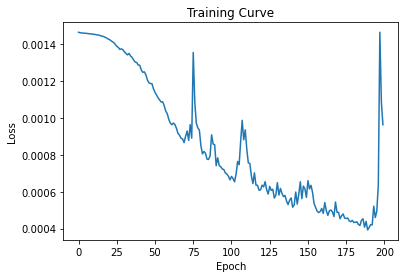

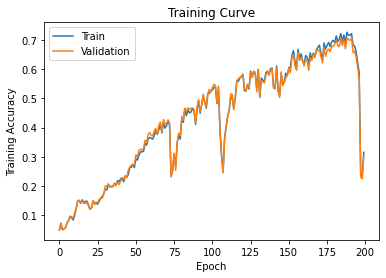

Final Training Accuracy: 0.31564285714285717
Final Validation Accuracy: 0.304434811603868


In [ ]:
# Iteration #1
model = Classifier()

if use_cuda and torch.cuda.is_available():
  model.cuda()
  print('CUDA is available!  Training on GPU ...')
else:
  print('CUDA is not available.  Training on CPU ...')

train(model, resnet_train_data, resnet_val_data, batch_size=2048, learning_rate=0.007, num_epochs=200)

CUDA is available!  Training on GPU ...
Epoch 1: Train acc: 0.05714285714285714 | Validation acc: 0.05701900633544515
Epoch 2: Train acc: 0.1437142857142857 | Validation acc: 0.1470490163387796
Epoch 3: Train acc: 0.1785 | Validation acc: 0.18406135378459487
Epoch 4: Train acc: 0.22778571428571429 | Validation acc: 0.22840946982327442
Epoch 5: Train acc: 0.279 | Validation acc: 0.2677559186395465
Epoch 6: Train acc: 0.3697857142857143 | Validation acc: 0.3821273757919306
Epoch 7: Train acc: 0.325 | Validation acc: 0.32577525841947313
Epoch 8: Train acc: 0.30114285714285716 | Validation acc: 0.29709903301100365
Epoch 9: Train acc: 0.45071428571428573 | Validation acc: 0.4538179393131044
Epoch 10: Train acc: 0.5014285714285714 | Validation acc: 0.49749916638879627
Epoch 11: Train acc: 0.462 | Validation acc: 0.4598199399799933
Epoch 12: Train acc: 0.4000714285714286 | Validation acc: 0.39379793264421475
Epoch 13: Train acc: 0.5329285714285714 | Validation acc: 0.5265088362787596
Epoch 14

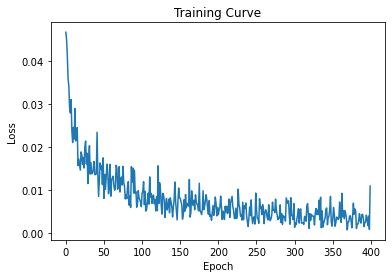

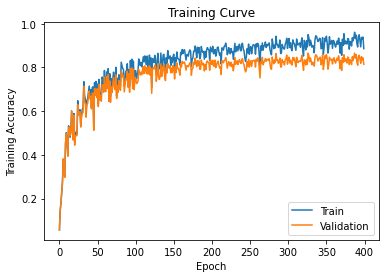

Final Training Accuracy: 0.8857857142857143
Final Validation Accuracy: 0.8142714238079359


In [36]:
# FINAL ITERATION
use_cuda = True

model = Classifier()

if use_cuda and torch.cuda.is_available():
  model.cuda()
  print('CUDA is available!  Training on GPU ...')
else:
  print('CUDA is not available.  Training on CPU ...')

train(model, resnet_train_data, resnet_val_data, batch_size=64, learning_rate=0.005, num_epochs=400)

# Evaluation of the Model on New Data: Quantitative and Qualitative Analysis

In [24]:
# Download The Best Primary Model
resNet = torchvision.models.resnet50(pretrained=True)
model = Classifier()
use_cuda = True

if use_cuda and torch.cuda.is_available():
  model.cuda()
  resNet.cuda()

model_path = get_model_name(model.name, batch_size=64, learning_rate=0.005, epoch=396)
state = torch.load(model_path)
model.load_state_dict(state)
print(f"Model Downloaded")

# Get test accuracy of this model 
test_acc = get_accuracy(model, resnet_test_data, 64)
print(f"Model Test Accuracy: {test_acc}")

Model Downloaded
Model Test Accuracy: 0.8563333333333333


In [27]:
# Helper Functions in our Analysis
def obtainImgFromPath(img_path):
    image = Image.open(img_path)
    
    transform = transforms.Compose([
        transforms.PILToTensor()
    ])
    
    img = transform(image)

    img = torch.unsqueeze(img, 0)
    img = img/255
    img = img.cuda()
    return img
    
def get_label_from_index(index):
    lt = os.listdir(NEW_DATASET_PATH)
    return lt[index]

In [21]:
# Class to represent F1 Score information
class F1score:
    def __init__(self):
        self.false_positive = 0
        self.false_negitive = 0
        self.true_positive = 0
        self.true_negitive = 0
        self.total = 0
    
    def __str__(self):
        return f"F1 Score: {self.calculateF1Score()}"

    def addFP(self):
        self.false_positive += 1
        self.total += 1
    def addFN(self):
        self.false_negitive += 1
        self.total += 1
    def addTP(self):
        self.true_positive += 1
        self.total += 1
    def addTN(self):
        self.true_negitive += 1
        self.total += 1
    def obtainInformation(self):
        change = False
        if self.total == 0:
            change = True
            self.total = 1
        output = {}
        output[ "FP" ] = self.false_positive / self.total
        output[ "FN" ] = self.false_negitive / self.total
        output[ "TP" ] = self.true_positive / self.total
        output[ "TN" ] = self.true_negitive / self.total
        output[ "Recall" ] = self.true_positive / (self.true_positive + self.false_negitive)
        output[ "Precision" ] = self.true_positive / (self.true_positive + self.false_positive)
        output[ "Accuracy" ] = (self.true_positive+self.true_negitive) / self.total
        if change:
            self.total = 0
        return output
    def calculateF1Score(self):
        out = self.obtainInformation()
        return (2*out["Recall"]*out["Precision"])/(out["Recall"]+out["Precision"]) 


In [22]:
def get_class_f1_score(model, data, batch_size):

    classes_f1_score = {}
    for id in range(20):
      classes_f1_score[id] = F1score()

    for imgs, labels in torch.utils.data.DataLoader(data, batch_size=batch_size, shuffle=True):
      #############################################
      #To Enable GPU Usage
      if use_cuda and torch.cuda.is_available():
        imgs = imgs.cuda()
        labels = labels.cuda()
      #############################################
      output = model(imgs)
      
      #select index with maximum prediction score
      pred = output.max(1, keepdim=True)[1]

      for index in range(len(labels)):
        if pred[index, 0] == labels[index]:
          classes_f1_score[int(labels[index])].addTP()
        else:
          classes_f1_score[int(labels[index])].addFN()
          classes_f1_score[int(pred[index, 0])].addFP()
        for id in range(20):
          if id == int(pred[index, 0]) or id == int(labels[index]):
            continue
          classes_f1_score[id].addTN()

    return classes_f1_score

In [25]:
classes_f1_score = get_class_f1_score(model, resnet_test_data, 64)

In [35]:
f1_list = [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]
for index in classes_f1_score:
    # print( f"{get_label_from_index(index)}: {classes_f1_score[index]}" )
    f1_list[index] = classes_f1_score[index].calculateF1Score()
print(f"Average F1 Score: {sum(f1_list)/20}")


Average F1 Score: 0.857630135570882


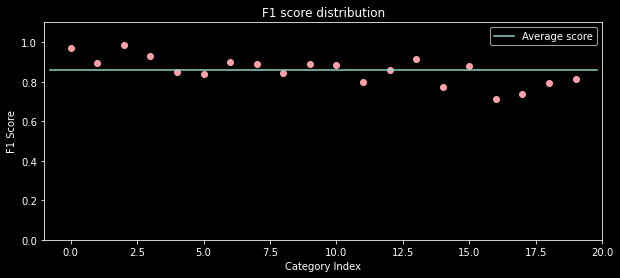

In [188]:
# Plot the F1 Distribution
plt.figure(figsize=(10, 4))
plt.style.use('dark_background')
ax = plt.axes()

ax.scatter( range(20), f1, color="#ffa1a7" )
ax.plot([-0.8, 19.8], [.857, .857], label='Average score')
ax.legend()

ax.set_ylabel('F1 Score')
ax.set_xlabel('Category Index')
plt.ylim(0,1.1)
plt.xlim(-1,20)
plt.title("F1 score distribution")

plt.show()


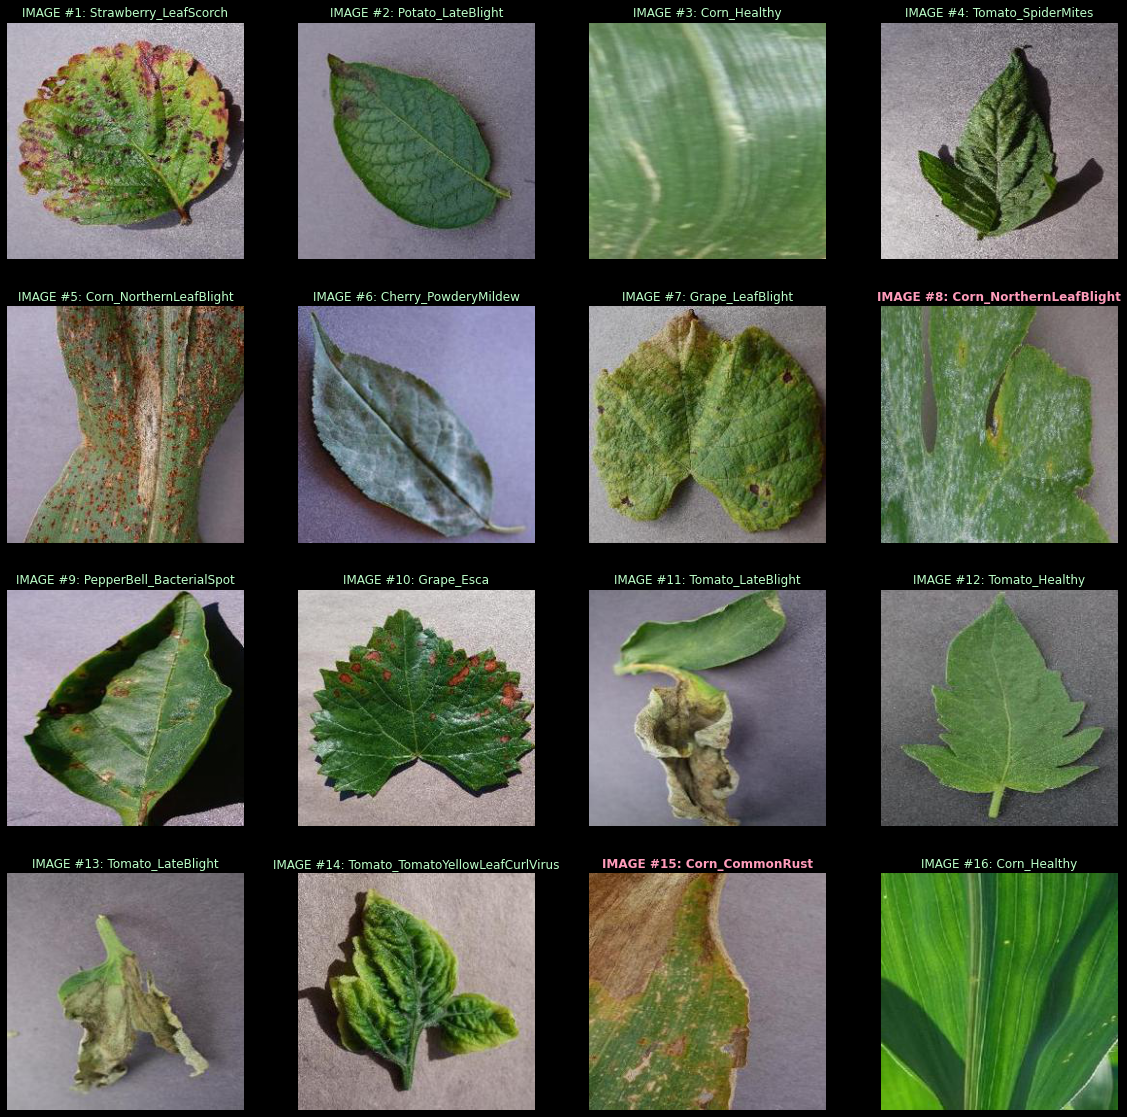

In [162]:
# Qualitatively Analyse the working of the model on 16 Random Data

plt.style.use('dark_background')
fig = plt.figure(figsize=(20,  20))
rows = 4
columns = 4

data = train_folder
use_cuda = False
for imgs, labels in torch.utils.data.DataLoader(data, batch_size=40, shuffle=True):
  #############################################
  #To Enable GPU Usage
  if use_cuda and torch.cuda.is_available():
    imgs = imgs.cuda()
    labels = labels.cuda()
  #############################################
  output = resNet(imgs)
  output = model(output)
  pred = output.max(1, keepdim=True)[1]
  
  count = 0
  total = 2
  for i, img in enumerate(imgs):
    
    if pred[i,0] != labels[i]:
      if count < 7:
        continue
      total -= 1
      if total < 0:
        continue

    sub_plot = fig.add_subplot(rows, columns, count+1)
    img = img.cpu()
    img = img.numpy()
    # np.rollaxis(img,0,3)
    img = np.transpose(img, (1,2,0))
    plt.imshow( img )
    plt.axis('off')
    
    if pred[i,0] == labels[i]:
      sub_plot.set_title(f"IMAGE #{count+1}: {get_label_from_index(pred[i,0])}", color="#bdffc9")
    else:
      sub_plot.set_title(f"IMAGE #{count+1}: {get_label_from_index(pred[i,0])}", color="#ff9cbb", fontweight='bold')
    
    count+=1
    if count == 16:
      break
  break

In [208]:
# Qualitatively Analyse the working of the model on 16 Specifically Selected Demo Data
import random
DEMO_DATASET_PATH = "Demo_Dataset"
x = os.listdir(DEMO_DATASET_PATH)
random.shuffle(x)


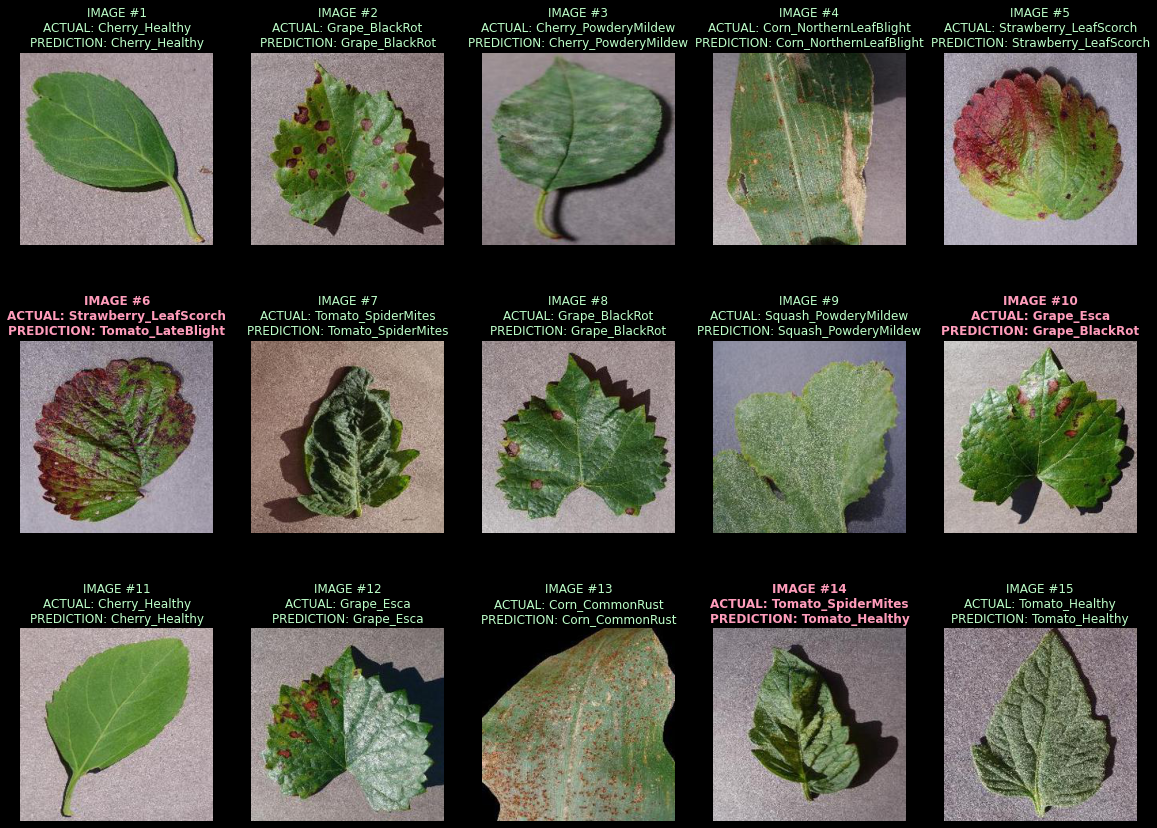

In [214]:
fig = plt.figure(figsize=(20, 15))
rows = 3
columns = 5
red = [5, 9, 13]
for i, img_name in enumerate(x):
    sub_plot = fig.add_subplot(rows, columns, i+1)

    img_path = os.path.join(DEMO_DATASET_PATH, img_name)
    img = obtainImgFromPath( img_path=img_path )

    # PASS THROUGH MODEL
    features = resNet(img)
    out = model(features)
    # pred = out.argmax(1)
    out = get_label_from_index(out.argmax(1))

    plt.imshow( plt.imread(img_path) )
    plt.axis('off')

    for index, char in enumerate(img_name):
        if img_name[index].isdigit():
            img_name = img_name[:index-1]
            break

    if i in red:
        sub_plot.set_title(f"IMAGE #{i+1}\nACTUAL: {img_name}\nPREDICTION: {out}", color="#ff9cbb", fontweight='bold')
    else:
        sub_plot.set_title(f"IMAGE #{i+1}\nACTUAL: {img_name}\nPREDICTION: {out}", color="#bdffc9")
